In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import (
    config_matplotlib,
    figsize,
    fig_save_and_show,
    plot_events_data,
    plot_efficiency_map_scattered,
)
from utils.optimization import (
    MyOptimizationProblem,
    convert_to_model_params,
    plot_optimization_params,
    plot_optimization_error,
    plot_compare,
    compute_metrics,
    save_model_params_to_json,
    load_model_params_from_json,
)
from utils.data import (
    get_events,
    get_sections,
    load_df,
    process_df,
    export_dataframe_to_latex,
)
from utils.sensitivity_analysis import (
    describe_param_with_uniform_distribution,
    describe_param_with_log_uniform_distribution,
    describe_param_with_triangular_distribution,
    describe_param_with_normal_distribution,
    describe_param_with_truncated_normal_distribution,
    describe_param_with_log_normal_distribution,
    wrapped_model_function,
    create_problem_spec_and_sample,
    plot_sampled_distribuitions,
    evaluate_problem,
    analyze_time_step,
    analyze_problem,
    sobol_sensitivity_analysis_from_model_params_to_outputs,
    plot_sensitivity_analysis,
    plot_sensitivity_analysis_heatmaps,
    get_region_mean,
    plot_sensitivity_analysis_bars,
)
from utils.control import (
    step_response,
    plot_step_response_dataframe,
    get_steady_state_map,
)

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/"

# Sensitivity Analysis

In [2]:
from model import DynamicMotor as Motor

Motor.build({})

<NonlinearIOSystem motor: ['motor_v', 'motor_q_load'] -> ['motor_i', 'motor_w']>

In [3]:
steady_state_params = load_model_params_from_json('me0909_steady_state_params.json')

motor_params = steady_state_params | {
    'motor_L_A': 50e-06,
    'motor_I_r': 1e-2,
    'motor_I_r_load': 0,
}

In [4]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Motor.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method="Radau",
    ).to_pandas()


def motor_sensitivity_analysis_step_response(
    params_description: dict,
    voltage_step: float,
    motor_load_torque_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Motor
    model_params = motor_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 0.1, 11, endpoint=True)

    # Input data
    U = (
        np.empty([model_tmp.ninputs, len(T)]) * np.nan
    )  # nan to force us to define every input
    U[model_tmp.input_labels.index("motor_v")] = voltage_step
    U[model_tmp.input_labels.index("motor_q_load")] = motor_load_torque_step

    # Initial state
    X0 = Motor.initial_state(X0={}, U0=U[:, 0], params=motor_params)

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=False,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=0.09, t_end=0.1)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}.tex",
        label=f"table:motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}",
        caption="Índices de Sobol em regime permanente",
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        fig_save_and_show(
            filename=f"{latex_img_path}/motor_sensitivity_analysis_distributions.pdf",
            save_title="Distribuição dos valores para cada fator",
            show_title="Distribution of the values for each factor",
            fig=plot_sampled_distribuitions(problem),
            ncols=3,
        )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_heatmaps_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_bars_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} em regime permanente, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} at steady-state with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem

In [5]:
# Setting all uncertainties to be x%
u_motor_R_A = 1 / 100
u_motor_B = 1 / 100
u_motor_K_Q = 1 / 100
u_motor_K_V = 1 / 100
u_motor_L_A = 1 / 100
u_motor_I_r = 1 / 100
u_motor_I_r_load = 1 / 100

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      2.237420e-05  1.227228e-04
                  ST      1.282618e-04  2.087676e-06
        motor_L_A S1     -8.882016e-08  2.099022e-06
                  ST      3.975851e-08  5.585496e-10
        motor_K_V S1      9.892923e-01  9.163708e-03
                  ST      9.898924e-01  6.383991e-03
        motor_K_Q S1      5.055268e-03  7.902109e-04
                  ST      5.305681e-03  6.141928e-05
        motor_I_r S1     -4.891183e-08  1.773969e-04
                  ST      2.427988e-04  3.008826e-06
        motor_B   S1      5.030843e-03  7.289486e-04
                  ST      5.031135e-03  5.425065e-05
motor_w motor_R_A S1      2.332763e-05  5.176209e-05
                  ST      2.464306e-05  3.154793e-07
        motor_L_A S1      3.446387e-09  3.009784e-07
                  ST      8.177278e-10  1.043327e-11
        motor_K_V S1      9.999262e-01  9.138954e-03
                  ST      9.999298e-01  6.348433e-03
        motor_K_Q S1      2.343303e-05  5.503034e-05
                  ST      2.469807e-05  2.914468e-07
        motor_I_r S1     -2.239470e-09  1.194598e-05
                  ST      1.130971e-06  1.397573e-08
        motor_B   S1      2.330716e-05  5.011179e-05
                  ST      2.330303e-05  2.545916e-07

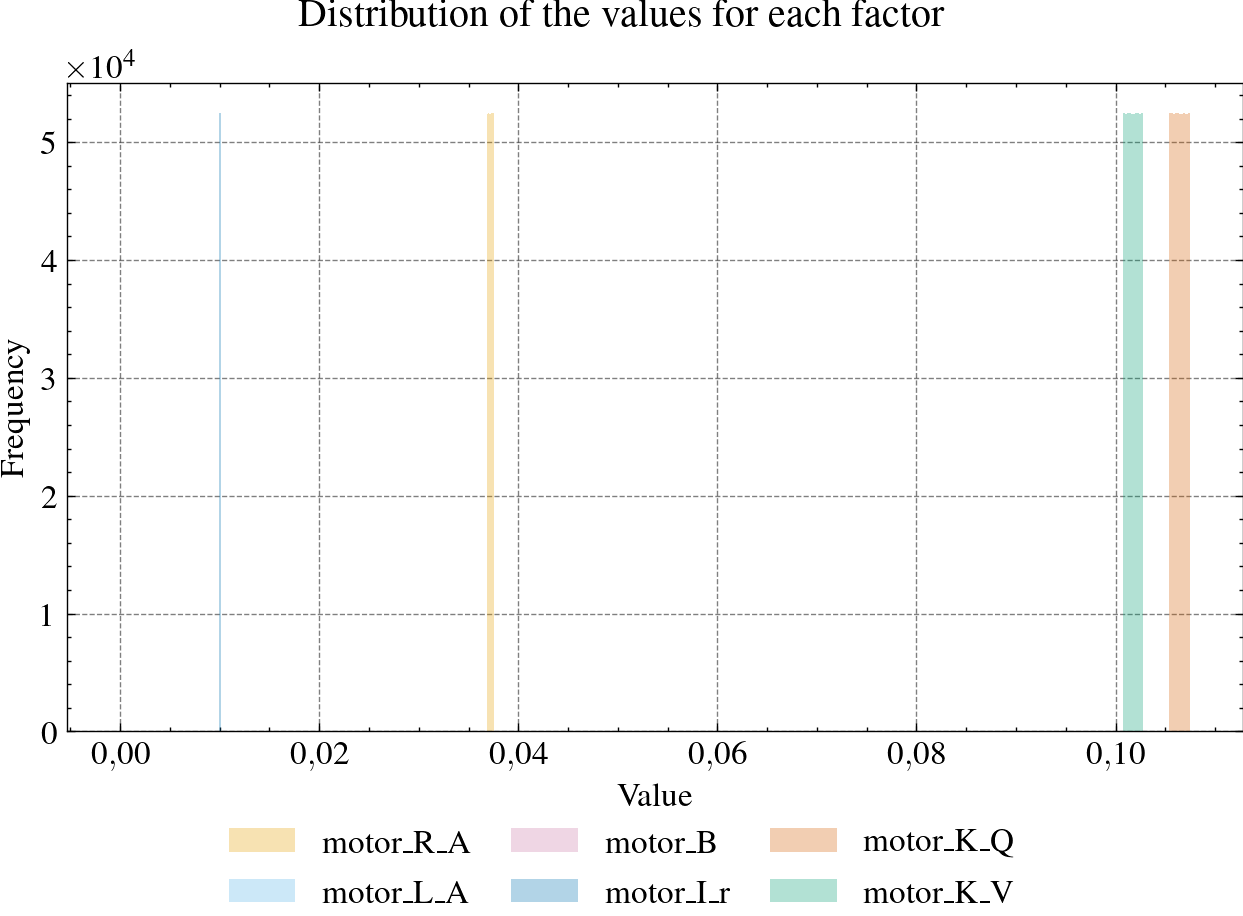

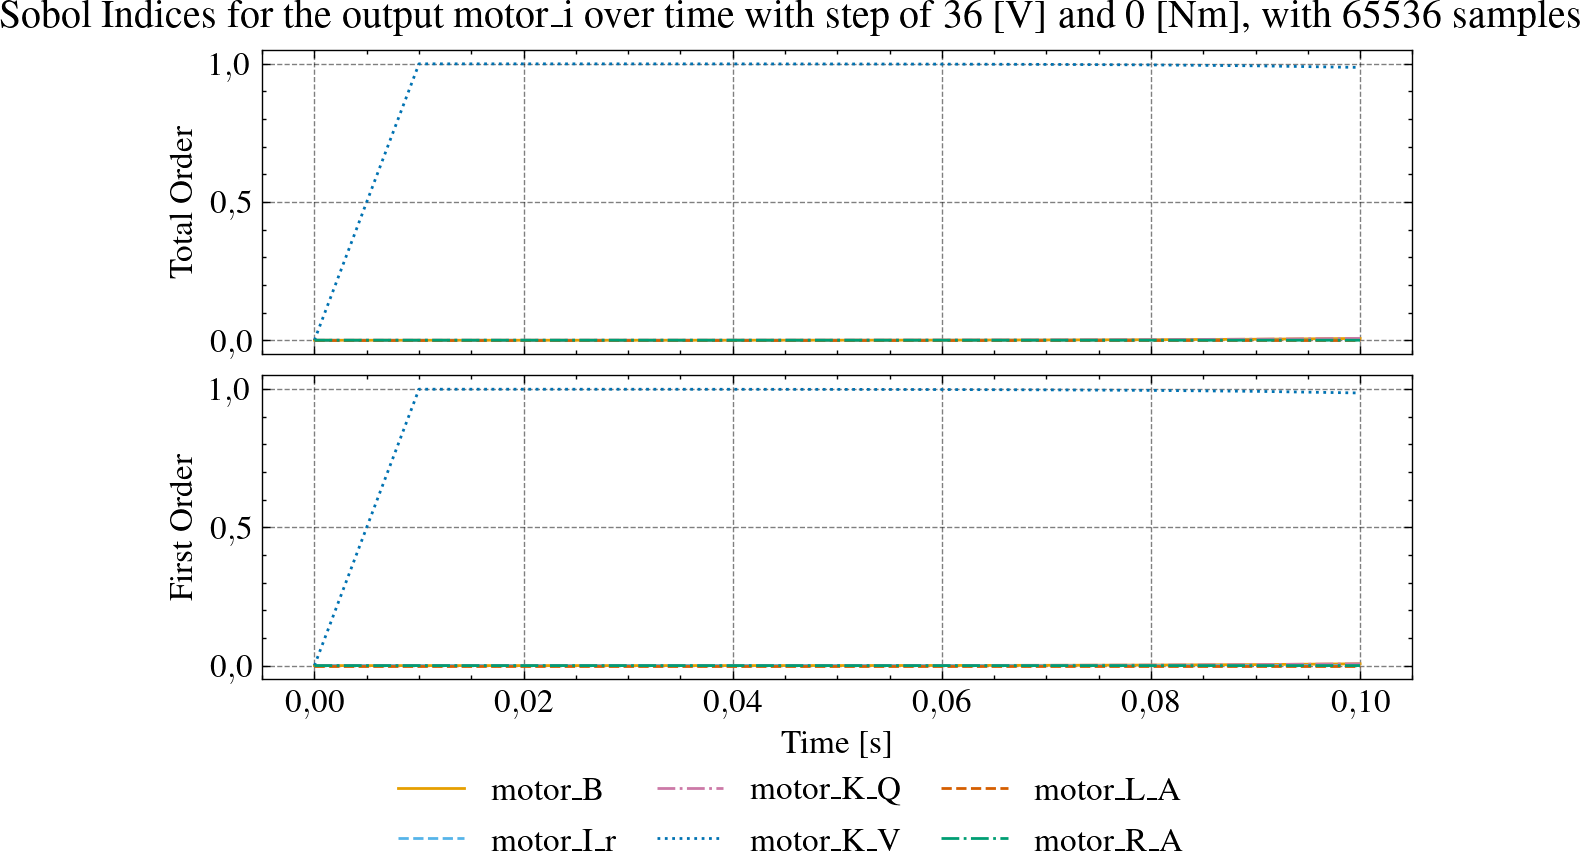

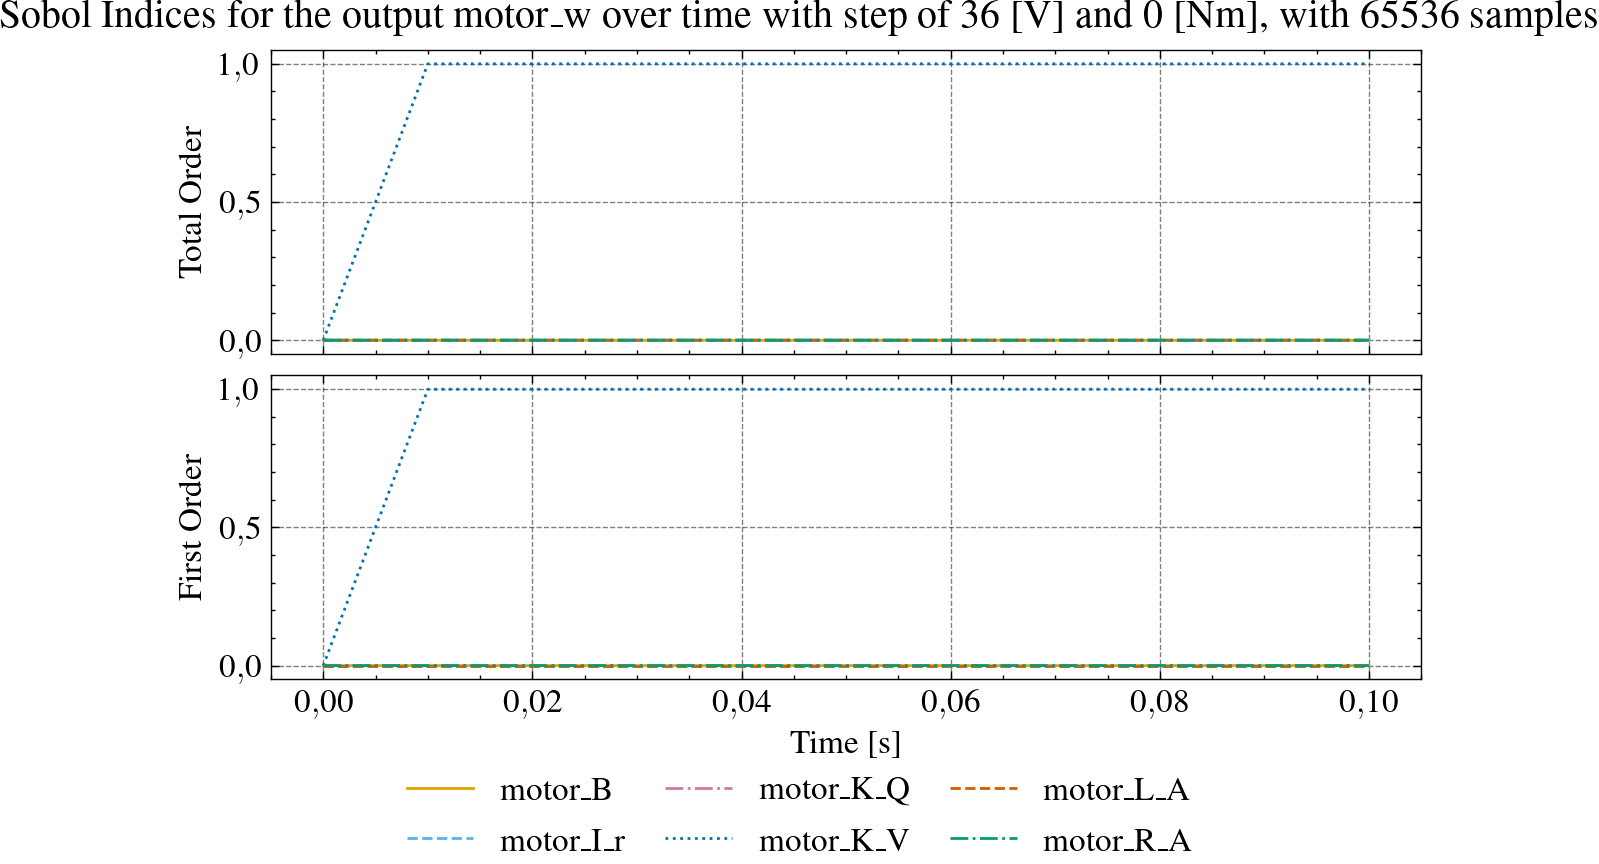

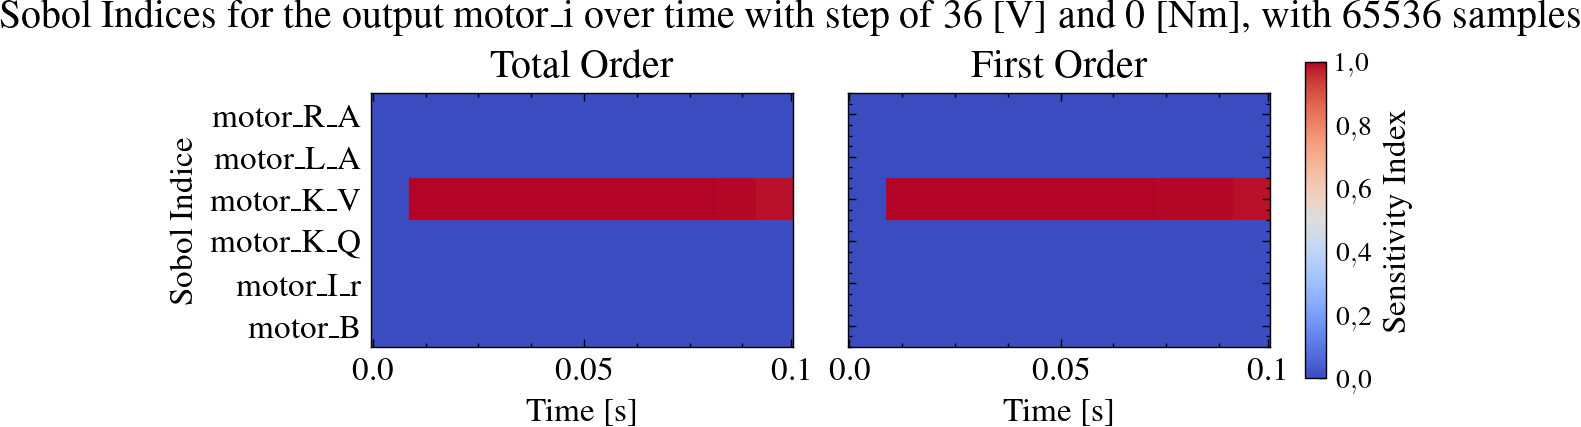

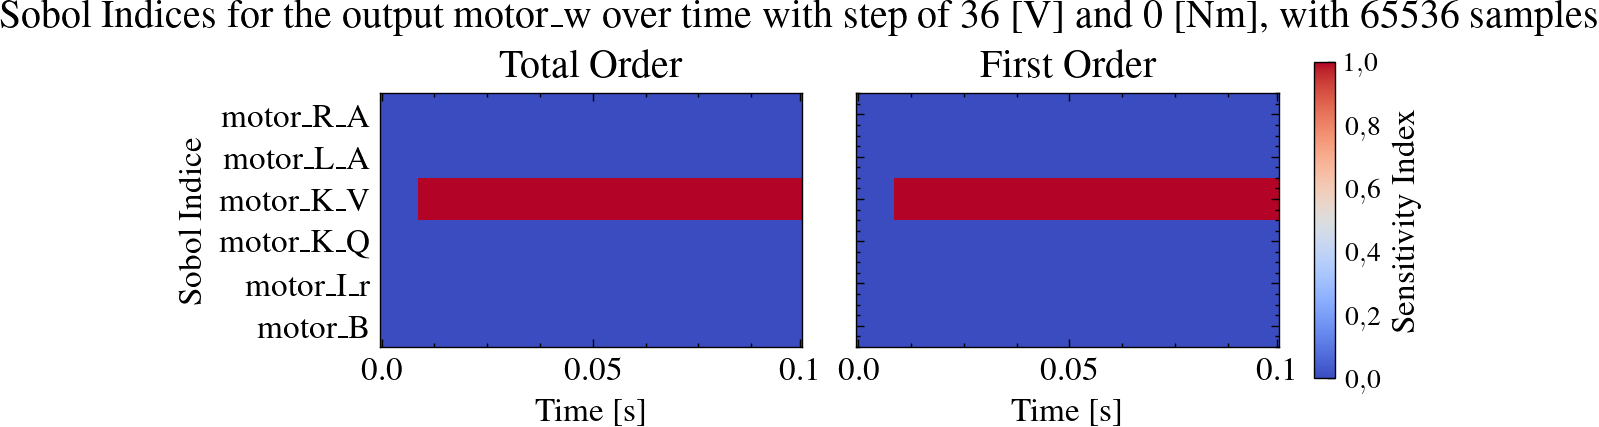

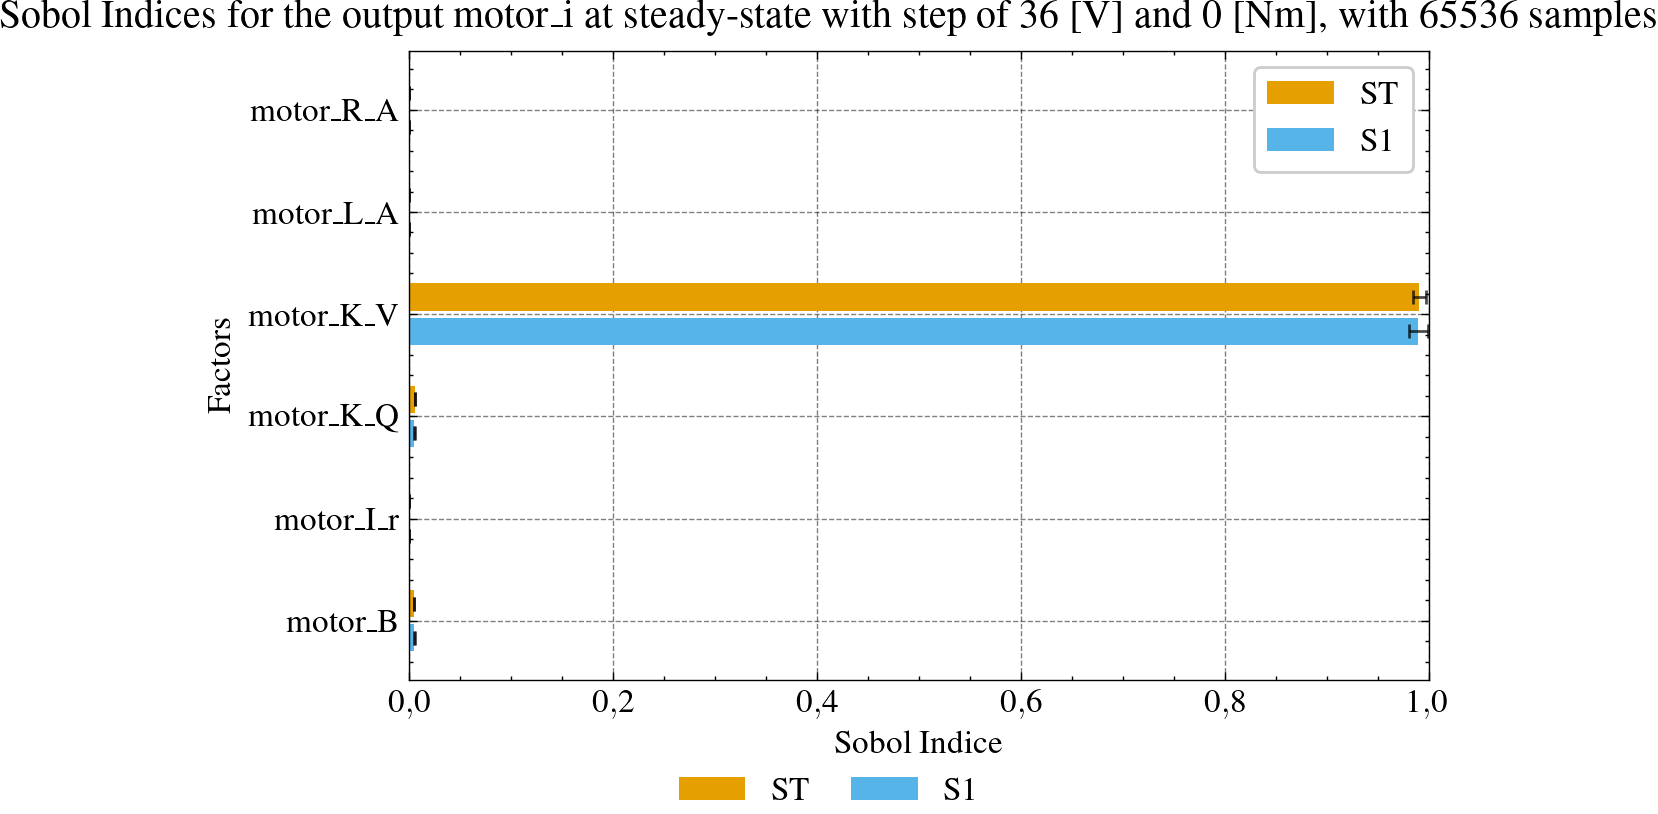

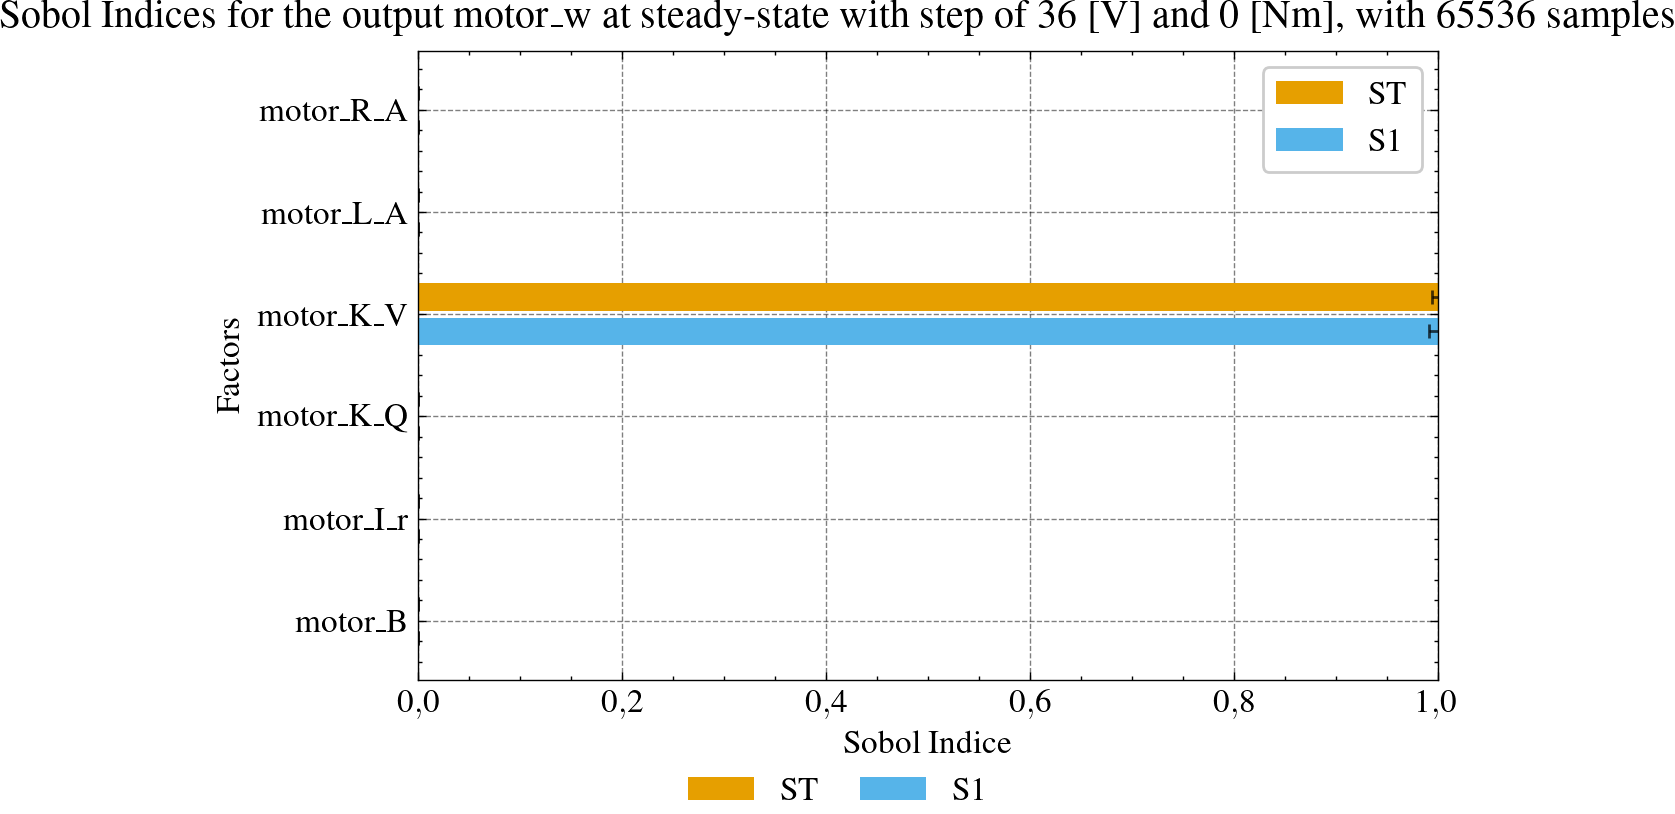

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      3.502353e-03  6.691304e-04
                  ST      3.527187e-03  4.389049e-05
        motor_L_A S1     -5.571419e-08  1.060832e-06
                  ST      1.196045e-08  2.630383e-10
        motor_K_V S1      2.750580e-01  4.669735e-03
                  ST      2.751985e-01  2.657736e-03
        motor_K_Q S1      7.199843e-01  7.872214e-03
                  ST      7.200435e-01  6.849191e-03
        motor_I_r S1      2.873947e-07  9.184781e-05
                  ST      6.758875e-05  9.587075e-07
        motor_B   S1      1.309620e-03  4.083075e-04
                  ST      1.309656e-03  1.386420e-05
motor_w motor_R_A S1      1.242736e-02  1.108212e-03
                  ST      1.243013e-02  1.485264e-04
        motor_L_A S1      1.010679e-08  3.039567e-07
                  ST      8.690547e-10  1.166909e-11
        motor_K_V S1      9.750535e-01  9.108737e-03
                  ST      9.750598e-01  6.564361e-03
        motor_K_Q S1      1.248996e-02  1.233112e-03
                  ST      1.249267e-02  1.299313e-04
        motor_I_r S1     -2.777938e-08  1.169353e-05
                  ST      1.126272e-06  1.394082e-08
        motor_B   S1      2.271236e-05  4.935835e-05
                  ST      2.272030e-05  2.537796e-07

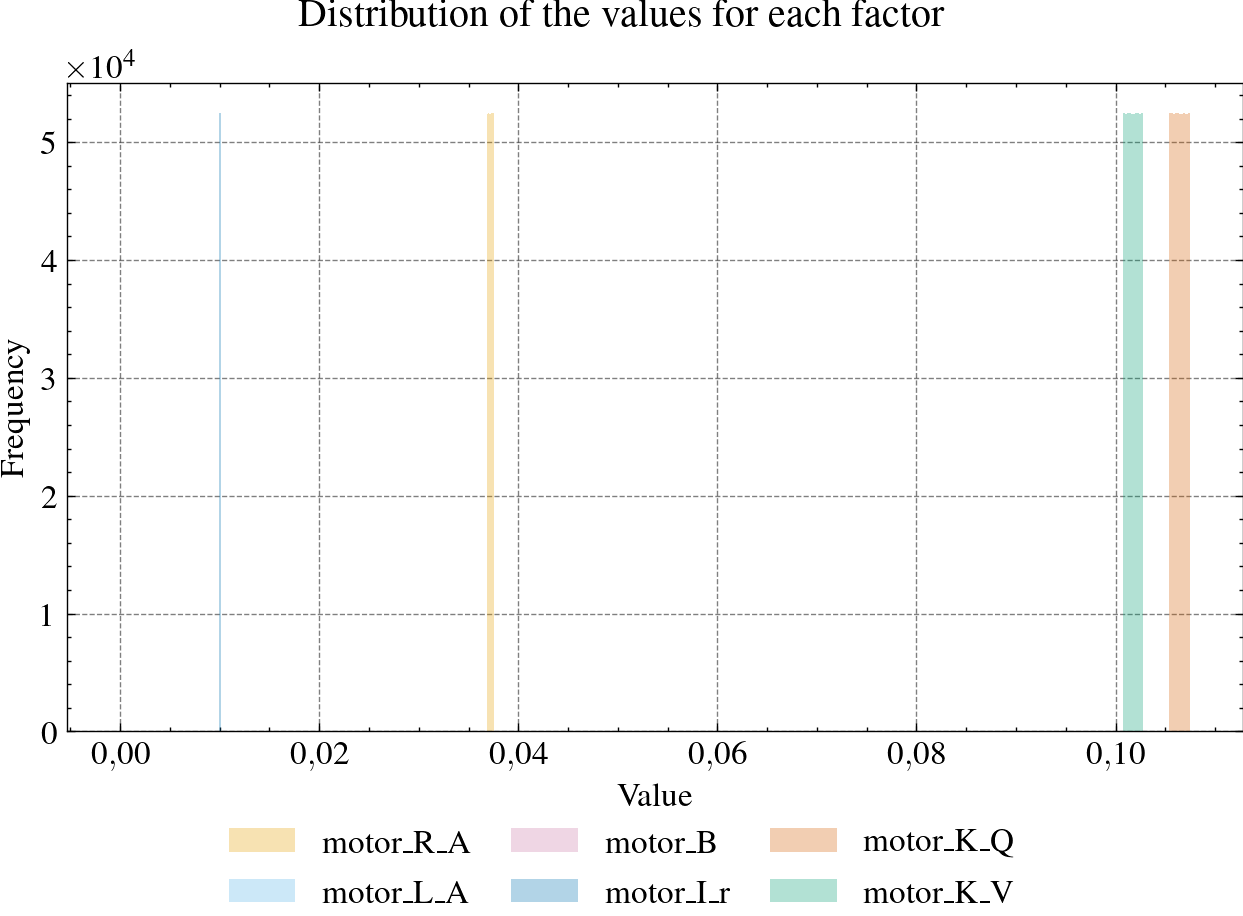

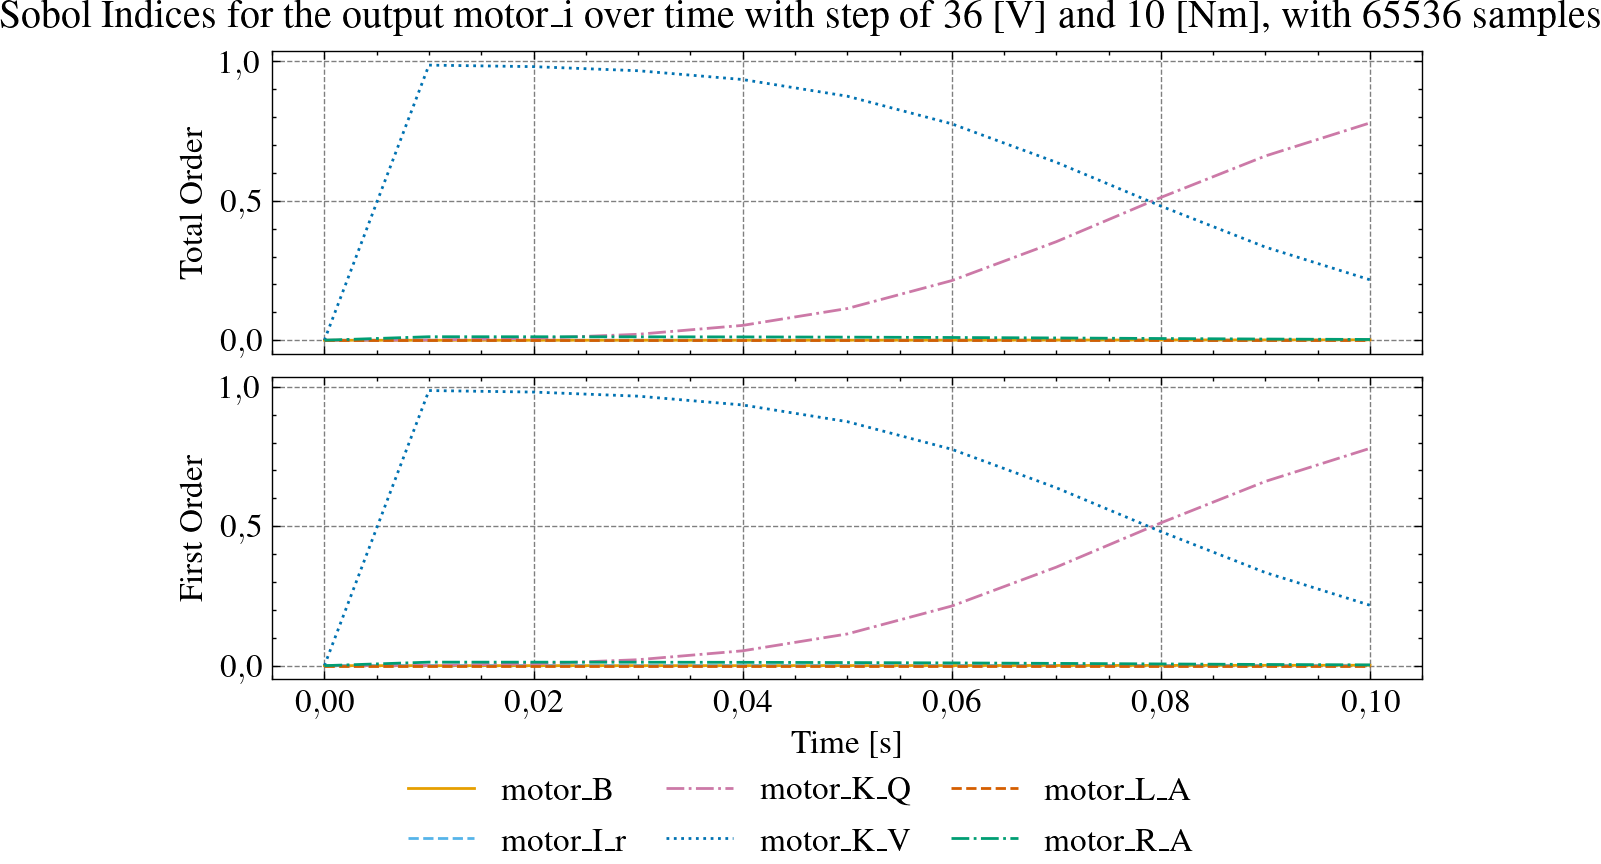

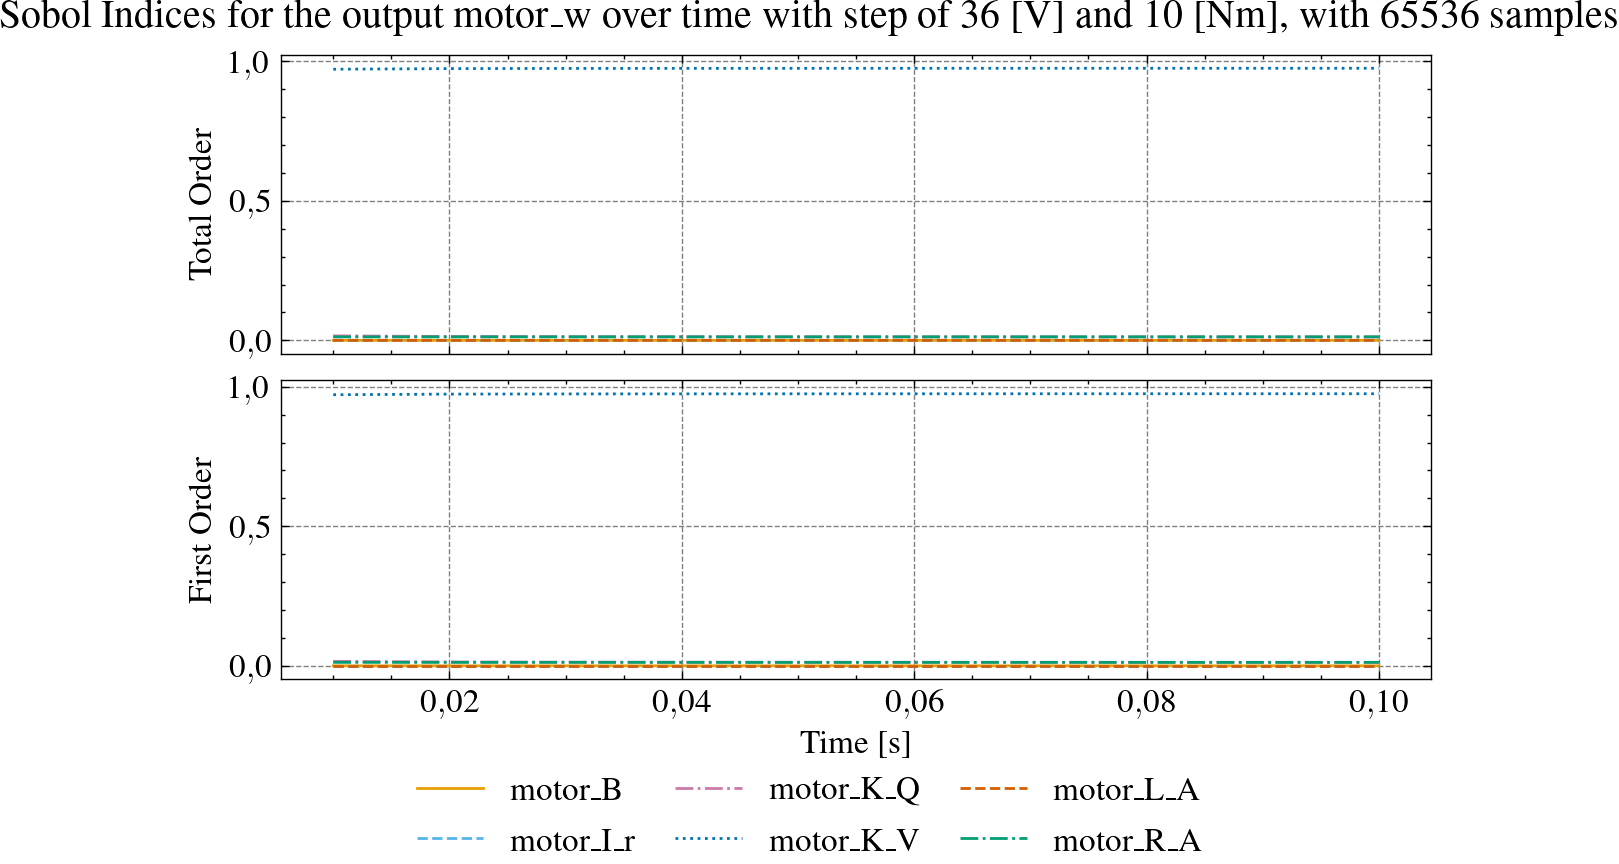

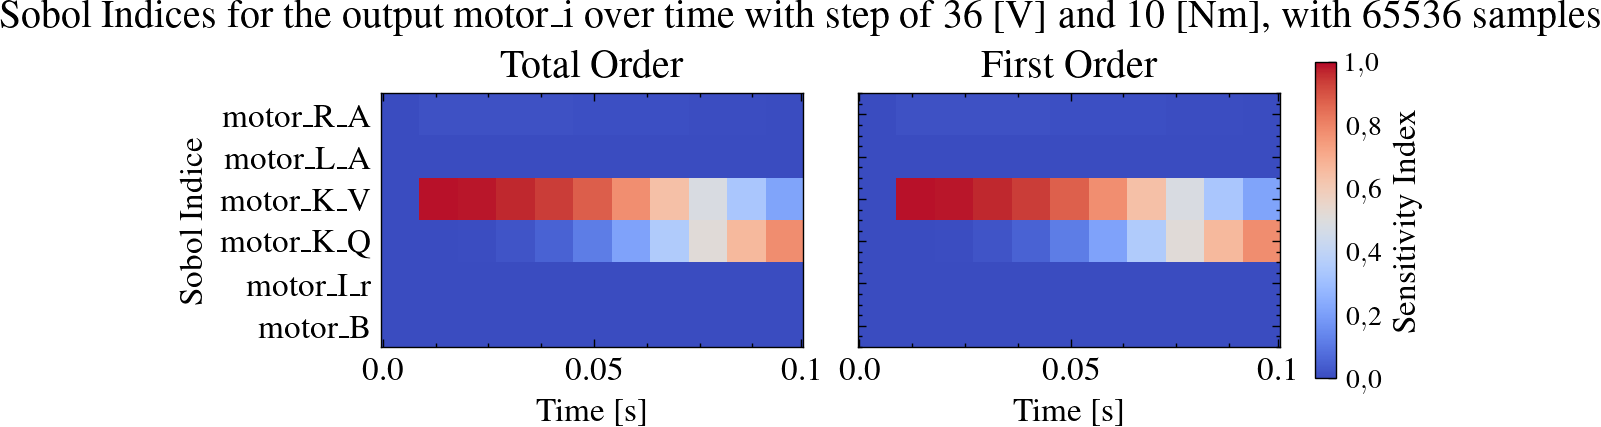

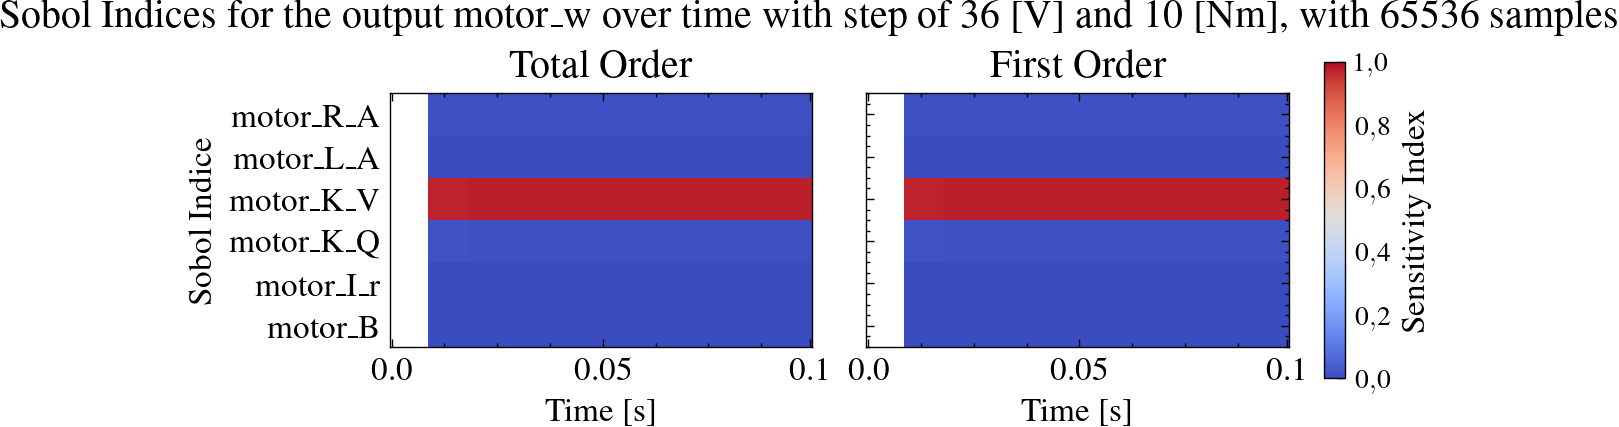

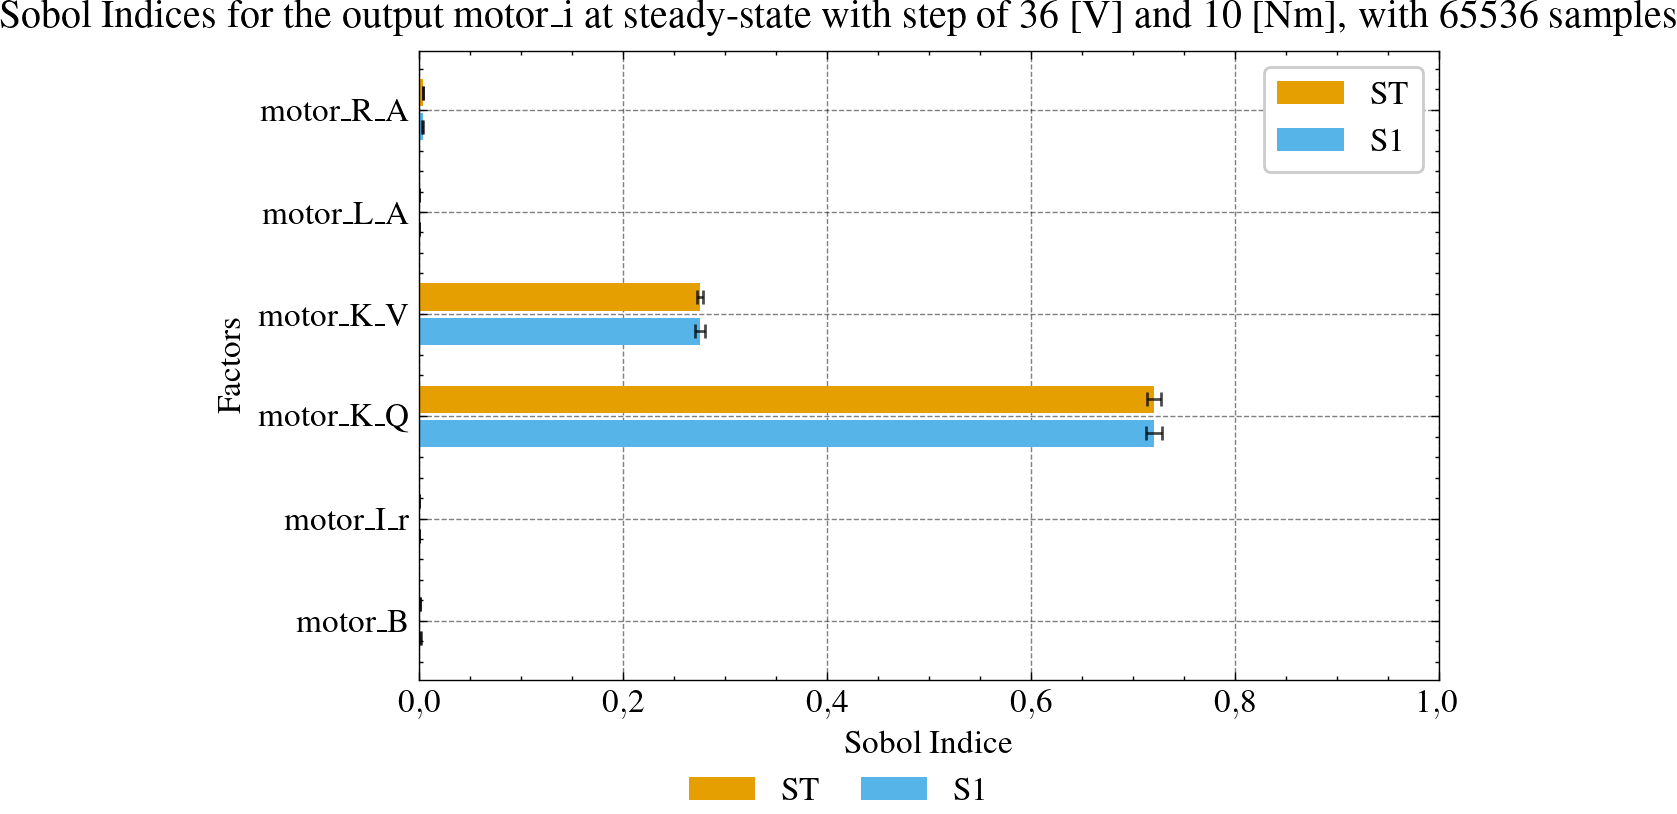

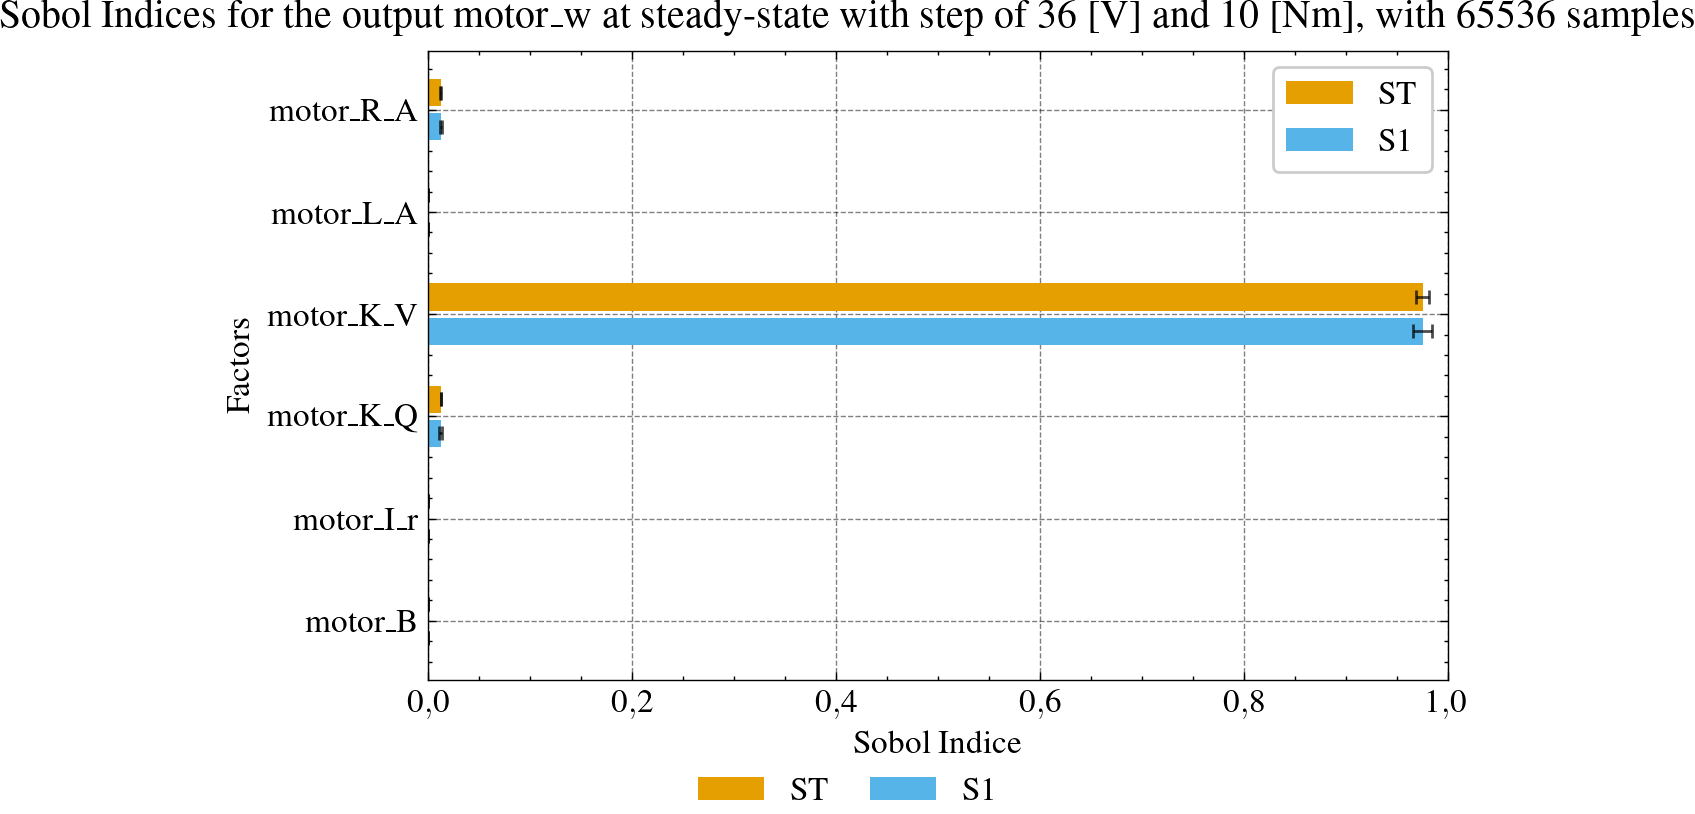

CPU times: user 8.8 s, sys: 10.2 s, total: 19 s
Wall time: 2min 9s


In [6]:
%%time

params_description = {
    'motor_R_A': describe_param_with_uniform_distribution(lower=motor_params['motor_R_A']*(1-u_motor_R_A), upper=motor_params['motor_R_A']*(1+u_motor_R_A)),
    'motor_L_A': describe_param_with_uniform_distribution(lower=motor_params['motor_L_A']*(1-u_motor_L_A), upper=motor_params['motor_L_A']*(1+u_motor_L_A)),
    'motor_B': describe_param_with_uniform_distribution(lower=motor_params['motor_B']*(1-u_motor_B), upper=motor_params['motor_B']*(1+u_motor_B)),
    'motor_I_r': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r']*(1-u_motor_I_r), upper=motor_params['motor_I_r']*(1+u_motor_I_r)),
    # 'motor_I_r_load': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r_load']*(1-u_motor_I_r_load), upper=motor_params['motor_I_r_load']*(1+u_motor_I_r_load)),
    'motor_K_Q': describe_param_with_uniform_distribution(lower=motor_params['motor_K_Q']*(1-u_motor_K_Q), upper=motor_params['motor_K_Q']*(1+u_motor_K_Q)),
    'motor_K_V': describe_param_with_uniform_distribution(lower=motor_params['motor_K_V']*(1-u_motor_K_Q), upper=motor_params['motor_K_V']*(1+u_motor_K_Q)),
}

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=0,
    samples=2**16,
    do_plot=True,
)

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=10,
    samples=2**16,
    do_plot=True,
)